# Featur Selection
The goal of this notebook is to create and **store a dataframe the final selection of features**, that we use for our DNNs. Generally the features can be devided into weather features, time features, and Lag Features. 

Before selection we consider: 
- **Weather Features x9**: 'temp', 'rhum', 'dwpt', 'wdir', 'wspd', 'pres' + Principal component analysis x3
- **Time Features x10**: 'hour', 'dayofweek', 'month', 'year', 'hour sin', 'hour cos', 'Hour sin cos', 'dayofweek sin', 'dayofweek cos', 'dayofweek sin cos'
- **LAG Features x7**: (Shifted electricity consumption): Shifted by 24, 48, 78, 96, 120, 144, 168 hours

Based on the generated features, we evaluate the forecasting performance and training time of 3 models (dense, cnn, and lstm model) regarding with different features. Based on the results, we select our final features. 

As a **Result** we consider the following features: 
**- ['hour sin', 'hour cos', 'temp', 'rhum', 'wspd', 'PC1', 'lag_24hrs']**

In [1]:
#Imports

#Data handling
import pandas as pd
#Create data arrays
import numpy as np
#Machine learning models
import tensorflow as tf
#Plotting
import matplotlib.pyplot as plt
#Create Folder for modelling checkpoint
import os
#Normalization
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from utils.modelgenerator import *

In [21]:
#Get data 
cwd = os.path.normpath(os.getcwd())
df = pd.read_csv(cwd+'/data/df_with_all_potential_features.csv', index_col='Date') #df = pd.read_csv('user5.csv')
df.index = pd.to_datetime(df.index)

In [24]:
"""#Save final dataframe
df_with_final_features = df[[
    'User1', 'User10', 'User11', 'User12', 'User13', 'User14', 'User15',
    'User16', 'User17', 'User18', 'User19', 'User2', 'User20', 'User21',
    'User22', 'User23', 'User24', 'User25', 'User26', 'User27', 'User28',
    'User29', 'User3', 'User30', 'User31', 'User32', 'User33', 'User34',
    'User35', 'User36', 'User4', 'User5', 'User6', 'User7', 'User8', 'User9',
    'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos',
    'User1_lag_24hrs', 'User2_lag_24hrs','User3_lag_24hrs','User4_lag_24hrs','User5_lag_24hrs',
    'User6_lag_24hrs','User7_lag_24hrs','User8_lag_24hrs','User9_lag_24hrs','User10_lag_24hrs',
    'User11_lag_24hrs', 'User12_lag_24hrs','User13_lag_24hrs','User14_lag_24hrs','User15_lag_24hrs',
    'User16_lag_24hrs','User17_lag_24hrs','User18_lag_24hrs','User19_lag_24hrs','User20_lag_24hrs',
    'User21_lag_24hrs', 'User22_lag_24hrs','User23_lag_24hrs','User24_lag_24hrs','User25_lag_24hrs',
    'User26_lag_24hrs','User27_lag_24hrs','User28_lag_24hrs','User29_lag_24hrs','User30_lag_24hrs',
    'User31_lag_24hrs', 'User32_lag_24hrs','User33_lag_24hrs','User34_lag_24hrs','User35_lag_24hrs',
    'User36_lag_24hrs'
]]
df_with_final_features.to_csv(cwd + '/data/df_with_final_features.csv')"""

<Axes: xlabel='Date'>

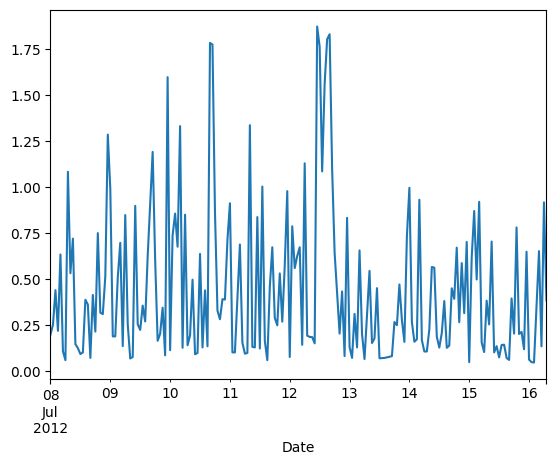

In [3]:
df['User1'][:200].plot()

In [4]:
#dff = df[[
#    'User2', 'User2_lag_24hrs', 'User2_lag_48hrs', 'User2_lag_78hrs', 'User2_lag_96hrs', 'User2_lag_120hrs', 'User2_lag_144hrs', 'User2_lag_168hrs',
#    'hour sin', 'hour cos', 'temp', 'rhum', 'wspd', 'PC1'
#]]

dff = df[[
    'User1'
]]

#settings = "User2: all time, weather, lags"
#settings = "User2: all time, weather, 2 lags"
#settings = "User1: all time, weather, 1 lags"
#settings = "User1: all time, weather, 0 lags"  
#settings = "User2: all time, weather - no PC1, 0 lags"
#settings = "User2: only time"
settings = "User2: only electricity"
#settings = "User2: time, weather PC1, 1 lag"
#settings = "User2: all time, temp"

dff.head()

,User1
Date,
2012-07-08 00:00:00,0.200
2012-07-08 01:00:00,0.253
2012-07-08 02:00:00,0.441
2012-07-08 03:00:00,0.220
2012-07-08 04:00:00,0.635


In [5]:
#Sequencing
sequence_length = 49
batch_size = 16

#Min Max Scaling
def min_max_scaling(df): #normailizing
    #Min Max Sclaing
    col_names = df.columns
    features = df[col_names]
    scaler = MinMaxScaler().fit(features.values)
    features = scaler.transform(features.values)
    df_scaled = pd.DataFrame(features, columns = col_names, index=df.index)
    return df_scaled

#Split the datasets into sequences of lngth=Sequence_length
def create_sequences(df, sequence_length):
    sequences = []
    for i in range(len(df) - sequence_length + 1):
        sequence = df.iloc[i:i+sequence_length, :]  # Take all columns
        sequences.append(sequence.values)
    return np.array(sequences)


# Split each sequence into X (features) and Y (labels)
def prepare_data(sequences):

    X = sequences[:, :-1, :].astype('float32') #For all sequences, Exclude last row of the sequence, take all columns
    y = sequences[:, -1, 0].astype('float32') #For all sequences, Take the last row of the sequence, take the first column

    #Adjust the training dataset size to be divisible by batch_size 
    # by discarding the remaining data points that don't fit into a complete batch.
    num_batches = len(X) // batch_size
    # Adjust the training dataset to contain only complete batches
    adjusted_X = X[:num_batches * batch_size]
    adjusted_y = y[:num_batches * batch_size]

    return adjusted_X, adjusted_y

In [6]:
#Create Train, Validation and Test datasets
n = len(dff)
train_df = dff[0:int(n*0.7)]
val_df = dff[int(n*0.7):int(n*0.9)]
test_df = dff[int(n*0.9):]

num_features = dff.shape[1] #4


train_df = min_max_scaling(train_df)
val_df = min_max_scaling(val_df)
test_df = min_max_scaling(test_df)

#Sequencing
sequence_length = 49
batch_size = 16

train_sequences = create_sequences(train_df, sequence_length)
val_sequences = create_sequences(val_df, sequence_length)
test_sequences = create_sequences(test_df, sequence_length)

X_train, y_train = prepare_data(train_sequences)
X_val, y_val = prepare_data(val_sequences)
X_test, y_test = prepare_data(test_sequences)

In [7]:
m1 = ModelGenerator()

horizon = 1
max_epochs = 50

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
metrics=[
    tf.keras.metrics.MeanAbsoluteError(),
]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,mode='min')
callbacks=[early_stopping]

dense_model = m1.build_dense_model(X_train, horizon, units=64)

lstm_model = m1.build_lstm_model(X_train, horizon, lstm_cells=64)

In [8]:
def plot_model_predictions(model, history, y_test, X_test, plt_length=200):
    # Plot training and validation loss
    plt.figure(figsize=(15, 3))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Make predictions on the test set
    y_pred = model.predict(X_test, batch_size=batch_size)

    # Plot prediction results
    plt.figure(figsize=(10, 3))
    plt.plot(y_test[:plt_length], label='True')
    plt.plot(y_pred[:plt_length], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('User')
    plt.legend()
    plt.show()

def compile_fit_evaluate_model(model, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, loss, optimizer,):
    
    #Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    # Train the model
    history = model.fit(X_train, y_train, epochs=max_epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)
    #Evaluate the model on test dataset
    test_loss = model.evaluate(X_test, y_test, batch_size=batch_size)
    print("Loss: ", test_loss)

    return history, test_loss

In [9]:
loss_evaluation = pd.DataFrame(columns=["Setting", "Model", "MSE", "MAE"])

In [10]:
# Number of repetitions
num_repetitions = 3

# Iterate through repetitions
for i in range(num_repetitions):
    dense_model = m1.build_dense_model(X_train, horizon, units=64)
    lstm_model = m1.build_lstm_model(X_train, horizon, lstm_cells=64)
    cnn_model = m1.build_cnn_model(X_train, horizon, filter=64, kernel_size=3)

    history_dense_model, test_loss_dense  = compile_fit_evaluate_model(
        dense_model, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam()
        )    
    history_lstm_model, test_loss_lstm  = compile_fit_evaluate_model(
        lstm_model, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam()
        )
    history_cnn_model, test_loss_cnn  = compile_fit_evaluate_model(
        cnn_model, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam()
        )
    
    new_data_dense = {
        "Setting": settings,
        "Model": "Dense",
        "MSE": test_loss_dense[0],   
        "MAE": test_loss_dense[1]    
    }

    new_data_lstm = {
        "Setting": settings,
        "Model": "LSTM",
        "MSE": test_loss_lstm[0],   
        "MAE": test_loss_lstm[1]   
    }

    new_data_cnn = {
        "Setting": settings,
        "Model": "CNN",
        "MSE": test_loss_cnn[0],    
        "MAE": test_loss_cnn[1]    
    }

    # Create a new DataFrame with your data
    new_row_df_dense = pd.DataFrame(new_data_dense, index=[0])
    new_row_df_lstm = pd.DataFrame(new_data_lstm, index=[0])
    new_row_df_cnn = pd.DataFrame(new_data_cnn, index=[0])

    # Concatenate the new DataFrame with the existing loss_evaluation DataFrame
    loss_evaluation = pd.concat([loss_evaluation, new_row_df_dense], ignore_index=True)
    loss_evaluation = pd.concat([loss_evaluation, new_row_df_lstm], ignore_index=True)
    loss_evaluation = pd.concat([loss_evaluation, new_row_df_cnn], ignore_index=True)

    print("Done: ", i)
    loss_evaluation

loss_evaluation

Epoch 1/50
372/372 [==============================] - 1s 1ms/step - loss: 0.0142 - mean_absolute_error: 0.0830 - val_loss: 0.0175 - val_mean_absolute_error: 0.0880
Epoch 2/50
372/372 [==============================] - 0s 1ms/step - loss: 0.0132 - mean_absolute_error: 0.0782 - val_loss: 0.0185 - val_mean_absolute_error: 0.0977
Epoch 3/50
372/372 [==============================] - 0s 1ms/step - loss: 0.0132 - mean_absolute_error: 0.0786 - val_loss: 0.0175 - val_mean_absolute_error: 0.0870
Epoch 4/50
372/372 [==============================] - 0s 1ms/step - loss: 0.0129 - mean_absolute_error: 0.0777 - val_loss: 0.0176 - val_mean_absolute_error: 0.0872
Epoch 5/50
372/372 [==============================] - 0s 1ms/step - loss: 0.0128 - mean_absolute_error: 0.0770 - val_loss: 0.0173 - val_mean_absolute_error: 0.0899
Epoch 6/50
372/372 [==============================] - 0s 1ms/step - loss: 0.0127 - mean_absolute_error: 0.0760 - val_loss: 0.0188 - val_mean_absolute_error: 0.1017
Epoch 7/50
372/3

,Setting,Model,MSE,MAE
0,User2: only electricity,Dense,0.031917,0.125865
1,User2: only electricity,LSTM,0.034258,0.118005
2,User2: only electricity,CNN,0.040199,0.143596
3,User2: only electricity,Dense,0.031161,0.126017
4,User2: only electricity,LSTM,0.033185,0.122794
5,User2: only electricity,CNN,0.035383,0.133187
6,User2: only electricity,Dense,0.031328,0.125825
7,User2: only electricity,LSTM,0.034188,0.136981
8,User2: only electricity,CNN,0.038366,0.151301


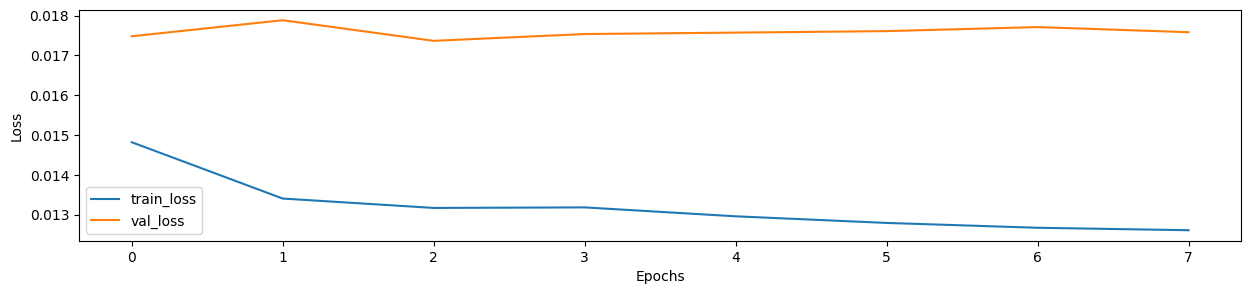

50/50 [==============================] - 0s 681us/step


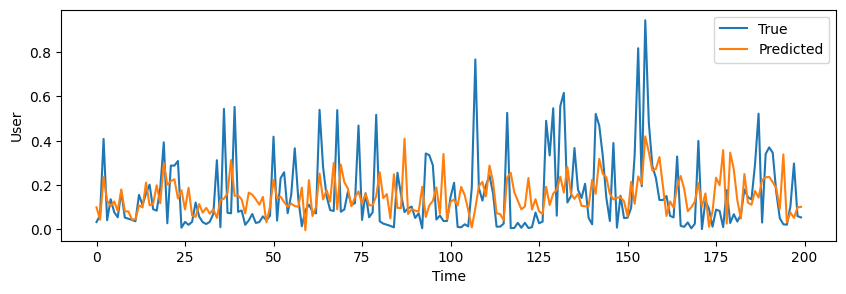

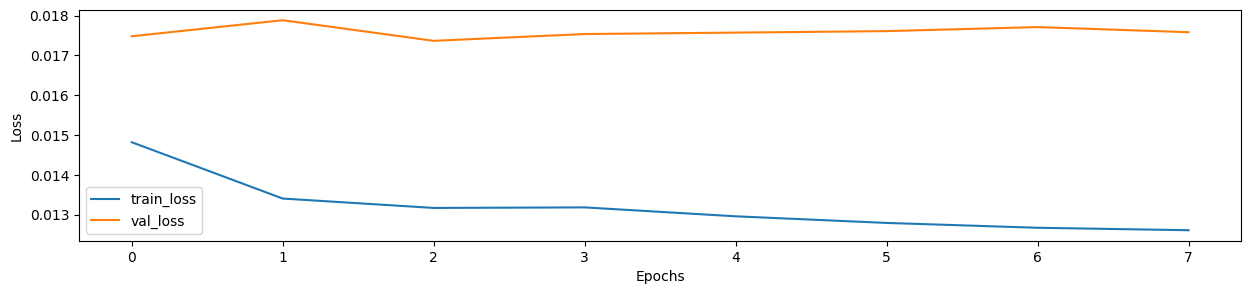

50/50 [==============================] - 1s 5ms/step


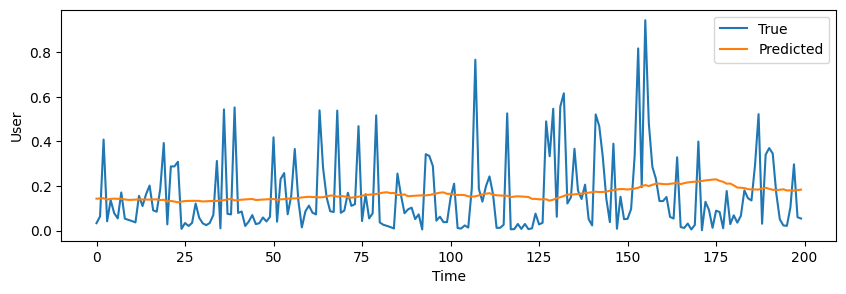

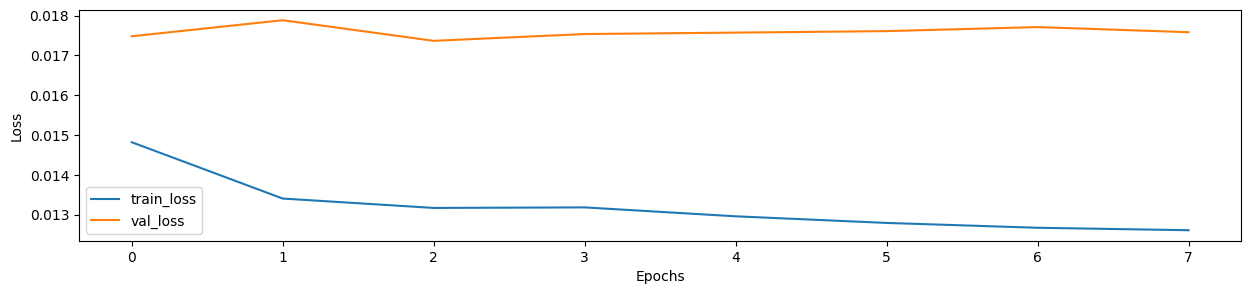

50/50 [==============================] - 0s 837us/step


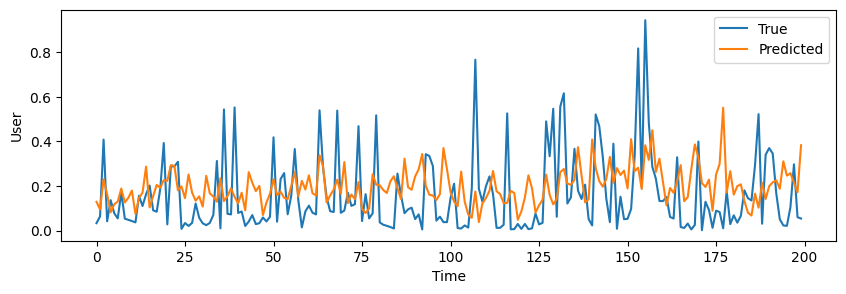

In [11]:
plot_model_predictions(dense_model, history_dense_model, y_test, X_test)
plot_model_predictions(lstm_model, history_dense_model, y_test, X_test)
plot_model_predictions(cnn_model, history_dense_model, y_test, X_test)

In [12]:
try: 
    # Try to load the DataFrame from the CSV file
    cwd = os.path.normpath(os.getcwd())
    all_loss_evaluation = pd.read_csv(cwd + '/data/df_with_all_feature_evaluation_losses_User1.csv')
    print("DataFrame loaded successfully!")
except FileNotFoundError:
    # If the CSV file doesn't exist, create a new DataFrame
    all_loss_evaluation = pd.DataFrame(columns=["Setting", "Model", "MSE-mean", "MSE-std", "MAE-mean","MAE-std"])
    print("DataFrame created!")


new_data_dense = {
        "Setting": settings,
        "Model": "Dense",
        "MSE-mean": loss_evaluation[loss_evaluation['Model'] == 'Dense']['MSE'].mean(), 
        "MSE-std": loss_evaluation[loss_evaluation['Model'] == 'Dense']['MSE'].std(),  
        "MAE-mean": loss_evaluation[loss_evaluation['Model'] == 'Dense']['MAE'].mean(), 
        "MAE-std": loss_evaluation[loss_evaluation['Model'] == 'Dense']['MAE'].std(), 
    }

new_data_lstm = {
        "Setting": settings,
        "Model": "LSTM",
        "MSE-mean": loss_evaluation[loss_evaluation['Model'] == 'LSTM']['MSE'].mean(), 
        "MSE-std": loss_evaluation[loss_evaluation['Model'] == 'LSTM']['MSE'].std(),  
        "MAE-mean": loss_evaluation[loss_evaluation['Model'] == 'LSTM']['MAE'].mean(), 
        "MAE-std": loss_evaluation[loss_evaluation['Model'] == 'LSTM']['MAE'].std(), 
    }

new_data_cnn = {
        "Setting": settings,
        "Model": "CNN",
        "MSE-mean": loss_evaluation[loss_evaluation['Model'] == 'CNN']['MSE'].mean(), 
        "MSE-std": loss_evaluation[loss_evaluation['Model'] == 'CNN']['MSE'].std(),  
        "MAE-mean": loss_evaluation[loss_evaluation['Model'] == 'CNN']['MAE'].mean(), 
        "MAE-std": loss_evaluation[loss_evaluation['Model'] == 'CNN']['MAE'].std(), 
    }

row_df_dense = pd.DataFrame(new_data_dense, index=[0])
row_df_lstm = pd.DataFrame(new_data_lstm, index=[0])
row_df_cnn = pd.DataFrame(new_data_cnn, index=[0])

# Concatenate the new DataFrame with the existing loss_evaluation DataFrame
all_loss_evaluation = pd.concat([all_loss_evaluation, row_df_dense], ignore_index=True)
all_loss_evaluation = pd.concat([all_loss_evaluation, row_df_lstm], ignore_index=True)
all_loss_evaluation = pd.concat([all_loss_evaluation, row_df_cnn], ignore_index=True)

DataFrame loaded successfully!


In [13]:
all_loss_evaluation



,Unnamed: 0,Setting,Model,MSE-mean,MSE-std,MAE-mean,MAE-std
0,0.0,"User1: all time, weather, 1 lags",Dense,0.034345,0.000436,0.128149,0.003692
1,1.0,"User1: all time, weather, 1 lags",LSTM,0.037015,0.004053,0.129294,0.010015
2,2.0,"User1: all time, weather, 1 lags",CNN,0.035984,0.000334,0.133864,0.000656
3,3.0,"User1: all time, weather, 0 lags",Dense,0.034279,0.001366,0.132708,0.003474
4,4.0,"User1: all time, weather, 0 lags",LSTM,0.037879,0.000871,0.136588,0.000874
5,5.0,"User1: all time, weather, 0 lags",CNN,0.039769,0.000881,0.140885,0.004606
6,6.0,"User2: all time, weather, 2 lags",Dense,0.035656,0.001289,0.133022,0.001256
7,7.0,"User2: all time, weather, 2 lags",LSTM,0.037331,0.004597,0.127124,0.003735
8,8.0,"User2: all time, weather, 2 lags",CNN,0.036369,0.002010,0.133391,0.000876
9,9.0,User2: only time,Dense,0.033234,0.000285,0.132034,0.003242


In [14]:
all_loss_evaluation.drop(["Unnamed: 0"], axis=1, inplace=True)
all_loss_evaluation


,Setting,Model,MSE-mean,MSE-std,MAE-mean,MAE-std
0,"User1: all time, weather, 1 lags",Dense,0.034345,0.000436,0.128149,0.003692
1,"User1: all time, weather, 1 lags",LSTM,0.037015,0.004053,0.129294,0.010015
2,"User1: all time, weather, 1 lags",CNN,0.035984,0.000334,0.133864,0.000656
3,"User1: all time, weather, 0 lags",Dense,0.034279,0.001366,0.132708,0.003474
4,"User1: all time, weather, 0 lags",LSTM,0.037879,0.000871,0.136588,0.000874
5,"User1: all time, weather, 0 lags",CNN,0.039769,0.000881,0.140885,0.004606
6,"User2: all time, weather, 2 lags",Dense,0.035656,0.001289,0.133022,0.001256
7,"User2: all time, weather, 2 lags",LSTM,0.037331,0.004597,0.127124,0.003735
8,"User2: all time, weather, 2 lags",CNN,0.036369,0.002010,0.133391,0.000876
9,User2: only time,Dense,0.033234,0.000285,0.132034,0.003242


In [15]:
all_loss_evaluation.to_csv(cwd + '/data/df_with_all_feature_evaluation_losses_User1.csv')

#loaded_loss_evaluation = pd.read_csv("loss_evaluation.csv")
#loaded_loss_evaluation

In [16]:
df_with_all_feature_evaluation_losses_model_aggregated = pd.DataFrame(columns=[
    "Setting 1", "Setting 2" ,	"Setting 3",	"Setting 4",	"Setting 5",	"Setting 6"])

all_settings_all_models_MSE_mean = {
        "Setting 1": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User1: all time, weather, 1 lags']['MSE-mean'].mean(),
        "Setting 2": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User1: all time, weather, 0 lags']['MSE-mean'].mean(),
        "Setting 3": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User2: all time, weather, 2 lags']['MSE-mean'].mean(),
        "Setting 4": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User2: only time']['MSE-mean'].mean(),
        "Setting 5": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User2: time, weather PC1, 1 lag']['MSE-mean'].mean(),
        "Setting 6": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User2: only electricity']['MSE-mean'].mean(),
    }

all_settings_all_models_MSE_std = {
        "Setting 1": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User1: all time, weather, 1 lags']['MSE-std'].mean(),
        "Setting 2": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User1: all time, weather, 0 lags']['MSE-std'].mean(),
        "Setting 3": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User2: all time, weather, 2 lags']['MSE-std'].mean(),
        "Setting 4": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User2: only time']['MSE-std'].mean(),
        "Setting 5": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User2: time, weather PC1, 1 lag']['MSE-std'].mean(),
        "Setting 6": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User2: only electricity']['MSE-std'].mean(),
    }

all_settings_all_models_MAE_mean = {
        "Setting 1": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User1: all time, weather, 1 lags']['MAE-mean'].mean(),
        "Setting 2": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User1: all time, weather, 0 lags']['MAE-mean'].mean(),
        "Setting 3": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User2: all time, weather, 2 lags']['MAE-mean'].mean(),
        "Setting 4": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User2: only time']['MAE-mean'].mean(),
        "Setting 5": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User2: time, weather PC1, 1 lag']['MAE-mean'].mean(),
        "Setting 6": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User2: only electricity']['MAE-mean'].mean(),
    }

all_settings_all_models_MAE_std = {
        "Setting 1": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User1: all time, weather, 1 lags']['MAE-std'].mean(),
        "Setting 2": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User1: all time, weather, 0 lags']['MAE-std'].mean(),
        "Setting 3": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User2: all time, weather, 2 lags']['MAE-std'].mean(),
        "Setting 4": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User2: only time']['MAE-std'].mean(),
        "Setting 5": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User2: time, weather PC1, 1 lag']['MAE-std'].mean(),
        "Setting 6": all_loss_evaluation[all_loss_evaluation['Setting'] == 'User2: only electricity']['MAE-std'].mean(),
    }


row_all_settings_all_models_MSE_mean = pd.DataFrame(all_settings_all_models_MSE_mean, index=[0])
row_all_settings_all_models_MSE_std = pd.DataFrame(all_settings_all_models_MSE_std, index=[0])
row_all_settings_all_models_MAE_mean = pd.DataFrame(all_settings_all_models_MAE_mean, index=[0])
row_all_settings_all_models_MAE_std = pd.DataFrame(all_settings_all_models_MAE_std, index=[0])


# Concatenate the new DataFrame with the existing loss_evaluation DataFrame
df_with_all_feature_evaluation_losses_model_aggregated = pd.concat([df_with_all_feature_evaluation_losses_model_aggregated, row_all_settings_all_models_MSE_mean], ignore_index=True)
df_with_all_feature_evaluation_losses_model_aggregated = pd.concat([df_with_all_feature_evaluation_losses_model_aggregated, row_all_settings_all_models_MSE_std], ignore_index=True)
df_with_all_feature_evaluation_losses_model_aggregated = pd.concat([df_with_all_feature_evaluation_losses_model_aggregated, row_all_settings_all_models_MAE_mean], ignore_index=True)
df_with_all_feature_evaluation_losses_model_aggregated = pd.concat([df_with_all_feature_evaluation_losses_model_aggregated, row_all_settings_all_models_MAE_std], ignore_index=True)

df_with_all_feature_evaluation_losses_model_aggregated["Measure"] = ["MSE-mean", "MSE-std", "MAE-mean", "MAE-std"]
df_with_all_feature_evaluation_losses_model_aggregated

,Setting 1,Setting 2,Setting 3,Setting 4,Setting 5,Setting 6,Measure
0,0.035781,0.037309,0.036452,0.036335,0.036907,0.034443,MSE-mean
1,0.001608,0.001039,0.002632,0.001387,0.001461,0.001143,MSE-std
2,0.130436,0.136727,0.131179,0.138229,0.142393,0.131508,MAE-mean
3,0.004788,0.002985,0.001956,0.007533,0.005059,0.006353,MAE-std


In [17]:
df_with_all_feature_evaluation_losses_model_aggregated.to_csv(cwd + '/data/df_with_all_feature_evaluation_losses_model_aggregated_User1.csv')